To visualize the features of different categories we use bar chart which is a very simple way of presenting the features. But when we are having a lot of features in one category then a bar chart will not help. In this case, the Bar Chart Race will come into use. 

In this project, we will create an animated bar chart. A bar chart race helps in visualizing the change in features over time for each category.

For the task of creating an animated bar chart race, we will be using a GDP per capita forecast dataset provided by the OECD. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker 
import matplotlib.animation as animation 
import matplotlib.colors as mc 
import colorsys 
from random import randint 
import re

We only need GDP per Capita as a feature for this task:

In [2]:
df = pd.read_csv("gdp per capita.csv") 
df = df.loc[df['Variable'] == 'GDP per capita in USA 2005 PPPs'] 

In [3]:
df = df[((df.Country != 'OECD - Total') & (df.Country != 'Non-OECD Economies')\
         & (df.Country != 'World') & ( df.Country != 'Euro area (15 countries)'))] 
df = df[['Country', 'Time', 'Value']] 

In [4]:
df = df.pivot(index='Country', columns='Time', values='Value') 
df = df.reset_index()

We will add a `^` to the name, so when we will display the unit of time, we can easily get rid of whatever is behind that particular character. 

When the last column of the data block is reached, the code generates an error because the `df.iloc` instruction cannot select a column (because it will be non-existent). Therefore, we will using a `try / except` statement:

In [6]:
for p in range(3):
    i = 0
    while i < len(df.columns): # while i &lt; len(df.columns):
        try:
            a = np.array(df.iloc[:, i + 1])
            b = np.array(df.iloc[:, i + 2])
            c = (a + b) / 2
            df.insert(i + 2, str(df.iloc[:, i + 1].name) + '^' +\
                      str(len(df.columns)), c)
        except:
            print(f"\n  Interpolation No. {p + 1} done...")
        i += 2


  Interpolation No. 1 done...

  Interpolation No. 2 done...

  Interpolation No. 3 done...


In [7]:
df = pd.melt(df, id_vars='Country', var_name='Time')

In [9]:
df.head()

,Country,Time,value
0,Australia,2010,35398.590665
1,Austria,2010,35273.436433
2,Belgium,2010,33010.373492
3,Brazil,2010,10092.706850
4,Canada,2010,36287.105162


When creating animations with Matplotlib, we always need a list of all images, which will be passed to the main function which draws each image. Here we create this list of frames by taking all the unique values from the series **time_unit** and converting it to a list:

In [10]:
frames_list = df["Time"].unique().tolist()
for i in range(10):
    frames_list.append(df['Time'].iloc[-1])

The following code assigns the colours of the bar graph. First of all, We are using a function which can turn any colour into a lighter / darker shade. It requires the **Colorsys** module that we imported at the beginning:

In [11]:
def transform_color(color, amount=0.5):
    try:
        c = mc.cnames[color]
    except:
        c = color
        c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [12]:
all_names = df['Country'].unique().tolist()
random_hex_colors = []

for i in range(len(all_names)):
    random_hex_colors.append('#' + '%06X' % randint(0, 0xFFFFFF))

In [13]:
rgb_colors = [transform_color(i, 1) for i in random_hex_colors]
rgb_colors_opacity = [rgb_colors[x] + (0.825,) for x in range(len(rgb_colors))]
rgb_colors_dark = [transform_color(i, 1.12) for i in random_hex_colors]

Now we are going to create a bar chart run in this particular time frame with the top elements using the correct colour from the **normal_colors** dictionary. 

In order to make the graph look nicer, we will draw a darker shade around each bar using the respective colour from the **dark_color** dictionary:

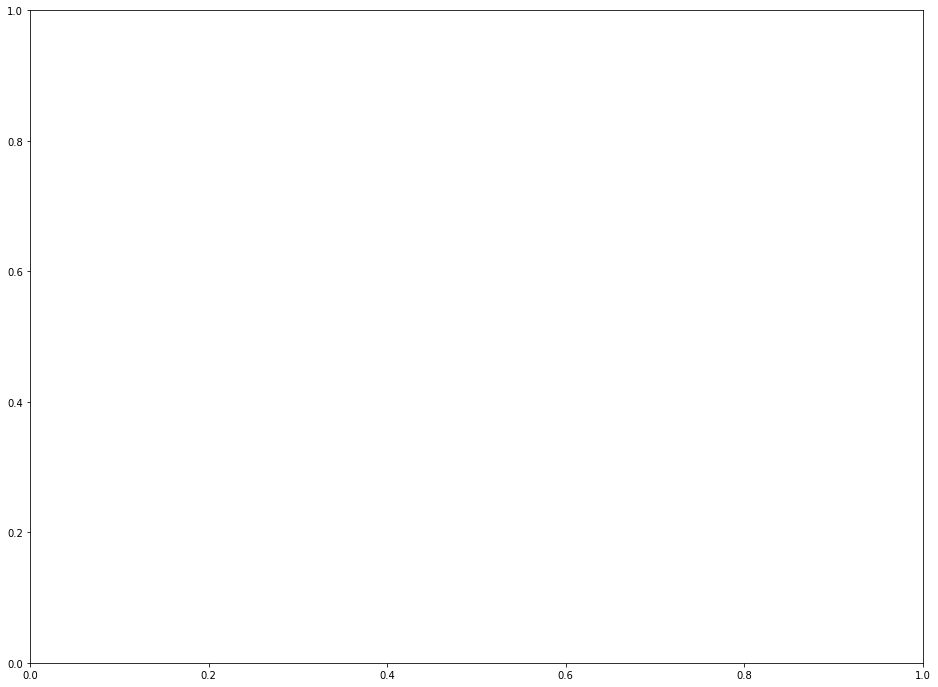

In [14]:
fig, ax = plt.subplots(figsize=(16, 12))

num_of_elements = 8


def draw_barchart(Time):
    df_frame = df[df['Time'].eq(Time)].sort_values(by='value', ascending=True).tail(num_of_elements)
    ax.clear()

    normal_colors = dict(zip(df['Country'].unique(), rgb_colors_opacity))
    dark_colors = dict(zip(df['Country'].unique(), rgb_colors_dark))

    ax.barh(df_frame['Country'], df_frame['value'], color=[normal_colors[x] for x in df_frame['Country']], height=0.8,
            edgecolor=([dark_colors[x] for x in df_frame['Country']]), linewidth='9')

    dx = float(df_frame['value'].max()) / 200

    for i, (value, name) in enumerate(zip(df_frame['value'], df_frame['Country'])):
        ax.text(value + dx, i + (num_of_elements / 50), '    ' + name,
                size=16, weight='bold', ha='left', va='center', fontdict={'fontname': 'Trebuchet MS'})
        ax.text(value + dx, i - (num_of_elements / 50), f'    {value:,.0f}', size=15, ha='left', va='center')

    time_unit_displayed = re.sub(r'\^(.*)', r'', str(Time))
    ax.text(1.0, 1.14, time_unit_displayed, transform=ax.transAxes, color='#666666',
            size=15, ha='right', weight='bold', fontdict={'fontname': 'Trebuchet MS'})
    ax.text(-0.005, 1.06, 'GDP/capita', transform=ax.transAxes, size=12, color='#666666')
    ax.text(-0.005, 1.14, 'GDP Per capita from 2010 to 2060', transform=ax.transAxes,
            size=15, weight='bold', ha='left', fontdict={'fontname': 'Trebuchet MS'})

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#345555', labelsize=10)
    ax.set_yticks([])
    ax.set_axisbelow(True)
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')

    plt.locator_params(axis='x', nbins=4)
    plt.box(False)
    plt.subplots_adjust(left=0.075, right=0.75, top=0.825, bottom=0.05, wspace=0.2, hspace=0.2)

The last step in every Matplotlib animation is to call the **FuncAnimation** method to run the bar chart race:



MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


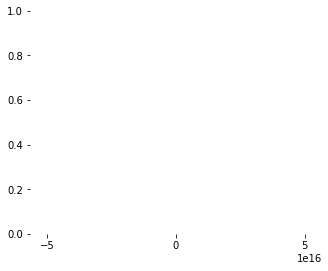

In [15]:
animator = animation.FuncAnimation(fig, draw_barchart, frames=frames_list)
animator.save('myAnimation.gif', writer='imagemagick', fps=30)
plt.show()